## **User Purchase Behaviour - EDA**
## How do demographics and product categories influence purchase behaviour?

This dataset, available on [Kaggle](https://www.kaggle.com/datasets/refiaozturk/online-shopping-dataset), was synthetically generated using ChatGPT to resemble realistic user purchasing behaviour. While it does not represent real customer data, it is suitable for practicing data cleaning, exploratory analysis, and decision-oriented reasoning.

Throughout this notebook, you will find not only code but also my comments and interpretations in markdown cells to explain the steps and results.

This file contains the following three sections:
1. Data Cleaning and Preparation
2. Exploratory Data Analysis (EDA)
3. Summary of Insights



In [2]:
# All import statements
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import numpy as np

In [3]:
# Load the CSV file to a pandas DataFrame
data = pd.read_csv('user_purchase_behaviour_dataset.csv')

data.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category
0,1,56.0,Female,USA,331.79,2021-11-21,Sports
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen
2,3,46.0,NaN,Germany,493.18,NaN,Books
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports
4,5,60.0,Female,UK,21.75,NaN,Beauty


In [4]:
# Display number of observations

print("Number of rows in the original dataset:", format(len(data), ',.0f'))

Number of rows in the original dataset: 15,000


## **Data Cleaning and Preparation**
Steps:
1. Analyze Missing Values
2. Perform Sanity Checks
3. Remove NA Values from our Cleaned DataFrame

## Step 1: Analyze Missing Values

In this section, we will inspect the dataset for missing values, check correlations across columns, and explore whether missing values are concentrated in specific segments.

In [5]:
# Check if there are any NA values

# Count missing values
missing_values = data.isna().sum()

# Calculate percentage
percentage_missing = (missing_values / len(data) * 100)

# Combine into a DataFrame
missing_table = pd.DataFrame({
    'Column Name': missing_values.index,
    'Number of NA': missing_values.values,
    'Percentage of NA': percentage_missing.values
})

# Sort by percentage of missing values descending
missing_table = missing_table.sort_values(by='Percentage of NA', ascending=False).reset_index(drop=True)

# Display the table
print("Missing values in the dataset:\n")
missing_table.style.format({'Percentage of NA': '{:.2f}%'})

Missing values in the dataset:



,Column Name,Number of NA,Percentage of NA
0,Purchase Amount,1800,12.00%
1,Age,1500,10.00%
2,Country,1200,8.00%
3,Purchase Date,1050,7.00%
4,Product Category,900,6.00%
5,Gender,750,5.00%
6,User ID,0,0.00%


**Are there any missing values in this dataset?**

Every column in this dataset has 5-12% missing values, which is a fairly low and normal proportion.

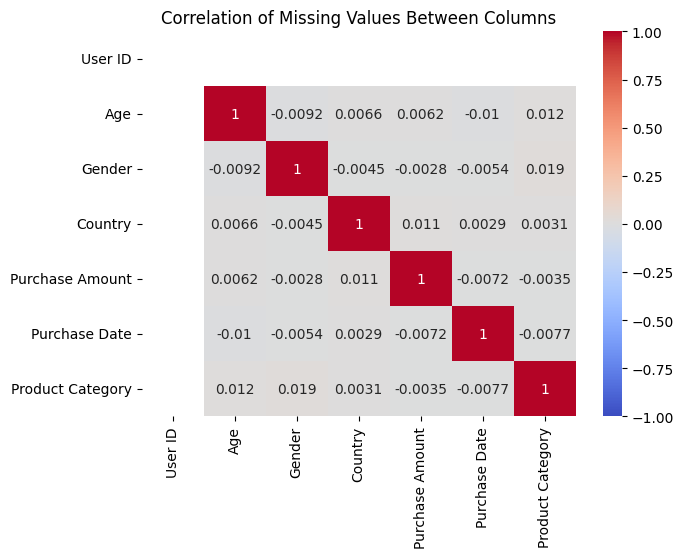

In [6]:
# Check if columns with missing values are correlated

# Create a boolean DataFrame: True if missing
missing_bool = data.isna()

# Compute correlations between missing values of columns
missing_corr = missing_bool.corr()

# Display as a heatmap
plt.figure(figsize=(7,5))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Missing Values Between Columns')
plt.show()


**Are missing values correlated across columns?**

The correlation matrix shows values close to 0, indicating that missing values are independent across columns.

In [7]:
# Check if any rows have all missing values

key_columns = ['Age', 'Gender', 'Country', 'Purchase Amount', 'Product Category']

# Boolean: True if all values in key columns are missing
rows_all_missing = data[key_columns].isna().all(axis=1)

# Display number of rows missing all key info
print(f"Rows missing all key info: {rows_all_missing.sum()}")

Rows missing all key info: 0


**Are certain rows missing all key info?**

The result above shows us that no rows have NA values across all key columns.

In [8]:
# Check if missing values are more common for certain segments

print("Missing Age values by Country\n")
missing_age_by_country = data.groupby('Country')['Age'].apply(lambda x: x.isna().sum())
print(missing_age_by_country)

print("\n\nMissing Gender values by Product Category\n")
missing_gender_by_category = data.groupby('Product Category')['Gender'].apply(lambda x: x.isna().sum())
print(missing_gender_by_category)


Missing Age values by Country

Country
Australia    216
Canada       230
France       231
Germany      247
UK           237
USA          211
Name: Age, dtype: int64


Missing Gender values by Product Category

Product Category
Beauty            109
Books             112
Clothing          112
Electronics       111
Home & Kitchen    118
Sports            128
Name: Gender, dtype: int64


**Are missing values concentrated in specific segments?**

The results above show that the variables "Country" and "Product Category" have similar numbers of missing values for "Age" and "Gender", respectively. No pattern was detected, so missing values can be considered randomly distributed.

In [9]:
# Compare some key variables to check if dropping NA values would
# significantly change the dataset

# Create a new df without NA values
no_missing = data.dropna()

# Compare the mean of the 'Purchase Amount' column before and after removing NA
print("'Purchase Amount' mean - original:", format(data['Purchase Amount'].mean(), ',.2f'))
print("'Purchase Amount' mean - after removing NA values:", format(no_missing['Purchase Amount'].mean(), ',.2f'))

print()

# Combine into a DataFrame
country_table = pd.DataFrame({
    'Proportions (original)': data['Country'].value_counts(normalize=True),
    'Proportions (after removing NA)': no_missing['Country'].value_counts(normalize=True)
})

print(country_table)

'Purchase Amount' mean - original: 253.22
'Purchase Amount' mean - after removing NA values: 252.44

           Proportions (original)  Proportions (after removing NA)
Country                                                           
Australia                0.163478                         0.162847
Canada                   0.165145                         0.168356
France                   0.177101                         0.180807
Germany                  0.168841                         0.165932
UK                       0.163841                         0.161635
USA                      0.161594                         0.160423


**Does dropping rows with NA values drastically change the dataset?**

To decide whether dropping rows with missing values is reasonable, we compared key statistics before and after removal:
* Mean purchase amount
* Proportion of users in each country in the dataset

Minimal differences were observed, so we can safely remove rows with missing values after completing sanity checks.

## Step 2: Perform Sanity Checks

In this section, we perform sanity checks to ensure all values are valid:
* Purchase Date: format YYYY-MM-DD
* Age: between 16 and 90
* Purchase Amount: positive values only
* Gender and Product Category: correct unique names
* No duplicate rows and nor duplicate transactions (based on User ID, Purchase Date, and Product Category)

All edits are saved in a new DataFrame to preserve the original data.

In [10]:
# Create a new dataframe to avoid overwriting the original
cleaned = data.copy()

In [11]:
# Date parsing

# Convert pandas Series into pandas datetime objects
cleaned['Purchase Date'] = pd.to_datetime(cleaned['Purchase Date']).dt.date

In [12]:
cleaned.head()

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category
0,1,56.0,Female,USA,331.79,2021-11-21,Sports
1,2,69.0,Male,Australia,335.72,2022-03-05,Home & Kitchen
2,3,46.0,NaN,Germany,493.18,NaT,Books
3,4,32.0,Male,Germany,80.97,2023-06-08,Sports
4,5,60.0,Female,UK,21.75,NaT,Beauty


In [13]:
# Check that 'Age' has reasonable values i.e. 16-90 years old

print(f"Min age in the dataset: {cleaned['Age'].min():,.0f} years old")
print(f"Max age in the dataset: {cleaned['Age'].max():,.0f} years old")
print()

# Convert age values to integers
cleaned['Age'] = cleaned['Age'].round().astype('Int64')

cleaned['Age'].head()

Min age in the dataset: 18 years old
Max age in the dataset: 69 years old



,Age
0,56
1,69
2,46
3,32
4,60


In [14]:
# Ensure prices are not negative values
print(f"Min purchase amount in the dataset: {cleaned['Purchase Amount'].min():,.2f}")

Min purchase amount in the dataset: 5.05


In [15]:
# Check 'Gender' unique values are not repeated nor misspelt

gender_unique = cleaned['Gender'].unique()
print("Unique values in the 'Gender' column:", gender_unique)

# Check 'Product Category' unique values are not repeated nor misspelt

product_unique = cleaned['Product Category'].unique()
print("\nUnique values in the 'Product Category' column:", product_unique)

Unique values in the 'Gender' column: ['Female' 'Male' nan 'Other']

Unique values in the 'Product Category' column: ['Sports' 'Home & Kitchen' 'Books' 'Beauty' 'Clothing' nan 'Electronics']


In [16]:
# Identify possible duplicates

# Check if there are any duplicate rows overall
count_duplicates = int(cleaned.duplicated().sum())
print("Number of duplicate rows overall:", count_duplicates)

# Check if there are any duplicate transactions
transactions_columns = ['User ID','Purchase Date', 'Product Category']
transactions_info = cleaned[transactions_columns]

transactions_duplicates = int(transactions_info.duplicated().sum())
print("\nNumber of duplicate transactions (ID-Date-Product):", transactions_duplicates)

Number of duplicate rows overall: 0

Number of duplicate transactions (ID-Date-Product): 0


## Step 3: Remove NA Values from our Cleaned DataFrame

After completing sanity checks, we remove all rows with missing values and continue using this cleaned DataFrame for the rest of the analysis.

In [17]:
# Remove NA values from the cleaned df
cleaned = cleaned.dropna()

# Display number of observations in the original dataset
print("Number of rows in the original dataset:", format(len(data), ',.0f'))

# Display new number of observations of the cleaned dataset
print("Number of rows in the cleaned dataframe, after removing NA values:", format(len(cleaned), ',.0f'))

# Calculate and display % of the dataset that is removed
removed_pct = (len(data) - len(cleaned)) / len(data) *100
print(f"\nPercentage of dataset removed: {removed_pct:,.2f}%")

Number of rows in the original dataset: 15,000
Number of rows in the cleaned dataframe, after removing NA values: 9,076

Percentage of dataset removed: 39.49%


##**Exploratory Data Analysis (EDA)**

In this section, we explore the dataset to understand how demographics and product categories relate to purchase behaviour.

We examine distributions, counts, and summary statistics using visualizations such as histograms, bar charts, boxplots, and line charts for trends over time.

In [18]:
# Format all numbers in all dataframes
pd.set_option('display.float_format', '{:,.2f}'.format)

# Display the top rows of the cleaned dataframe
cleaned.head(4)

,User ID,Age,Gender,Country,Purchase Amount,Purchase Date,Product Category
0,1,56,Female,USA,331.79,2021-11-21,Sports
1,2,69,Male,Australia,335.72,2022-03-05,Home & Kitchen
3,4,32,Male,Germany,80.97,2023-06-08,Sports
6,7,38,Female,Canada,222.20,2022-02-23,Beauty


In [19]:
# Display a summary of the DataFrame's structure and contents
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9076 entries, 0 to 14998
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User ID           9076 non-null   int64  
 1   Age               9076 non-null   Int64  
 2   Gender            9076 non-null   object 
 3   Country           9076 non-null   object 
 4   Purchase Amount   9076 non-null   float64
 5   Purchase Date     9076 non-null   object 
 6   Product Category  9076 non-null   object 
dtypes: Int64(1), float64(1), int64(1), object(4)
memory usage: 834.2+ KB


In [20]:
# Check if every row corresponds to a unique user and therefore transaction
print("Is each user ID in this column unique?")
cleaned['User ID'].is_unique


Is each user ID in this column unique?


True

**User ID**

Each User ID appears only once in the dataset, indicating that each row represents a distinct user and a single purchase per user.

In [21]:
# Generate a statistical summary of the column ' Age'
cleaned['Age'].describe()

,Age
count,"9,076.00"
mean,43.43
std,14.99
min,18.00
25%,30.00
50%,43.00
75%,56.00
max,69.00


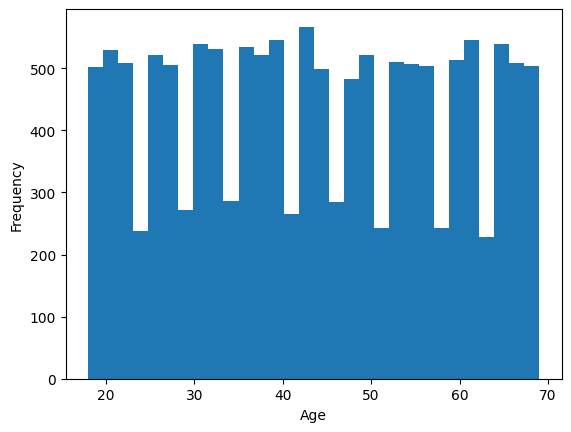

In [22]:
# Plot 'Age' column in a histogram
plt.hist(data['Age'], bins=30)
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.show()

**Age**

The age distribution is multimodal, showing several distinct groups of users concentrated in different age ranges.

In [23]:
# Generate a statistical summary of the column ' Purchase Amount'
cleaned['Purchase Amount'].describe()

,Purchase Amount
count,"9,076.00"
mean,252.44
std,144.01
min,5.05
25%,127.72
50%,252.69
75%,379.50
max,499.95


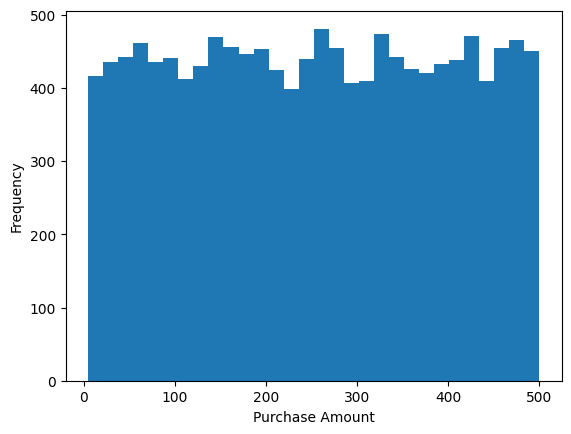

In [24]:
# Plot 'Purchase Amount' in a histogram
plt.hist(data['Purchase Amount'], bins=30)
plt.ylabel('Frequency')
plt.xlabel('Purchase Amount')
plt.show()


**Purchase Amount**

The histogram shows the distribution of purchase amounts, with the x-axis representing purchase amount ranges and the y-axis showing the number of purchases.

The mean and median are very similar, but the distribution is relatively uniform rather than bell-shaped, indicating it is not normally distributed.

In [28]:
# Perform correlation analysis between 'Age' and 'Purchase Amount'

correlation_coefficient = cleaned['Age'].corr(cleaned['Purchase Amount'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


Pearson Correlation Coefficient: -0.01


**Correlation analysis between Age and Purchase Amount**

Correlation analysis between Age and Purchase Amount shows very little linear relationship, as the correlation coefficient is close to 0.

        Count  Percentage (%)
Gender                       
Female   3082           34.00
Other    3001           33.10
Male     2993           33.00



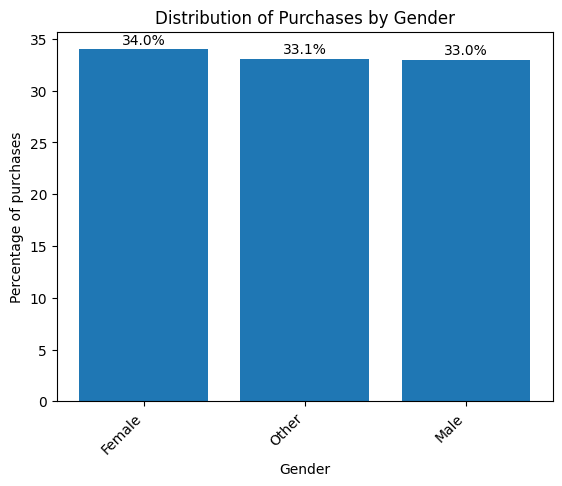

In [29]:
# Calculate and display the count and % of purchases per gender
gender_counts = cleaned['Gender'].value_counts()
gender_perc = cleaned['Gender'].value_counts(normalize=True) * 100

gender_table = pd.DataFrame({
    'Count': gender_counts,
    'Percentage (%)': gender_perc.round(1) # round to match labels on bars
})

print(gender_table)
print()

# Plot % in a bar chart
plt.figure()
plt.bar(
    gender_table.index,
    gender_table['Percentage (%)']
)
plt.title('Distribution of Purchases by Gender')
plt.ylabel('Percentage of purchases')
plt.xlabel('Gender')
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for i, v in enumerate(gender_table['Percentage (%)']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.show()

**Distribution of Purchases by Gender (bar chart)**

Women made the majority of purchases, but only slightly more than men and users in the “Other” category (~1% difference).

                  Count  Percentage (%)
Product Category                       
Clothing           1550           17.10
Sports             1518           16.70
Home & Kitchen     1517           16.70
Books              1508           16.60
Electronics        1492           16.40
Beauty             1491           16.40



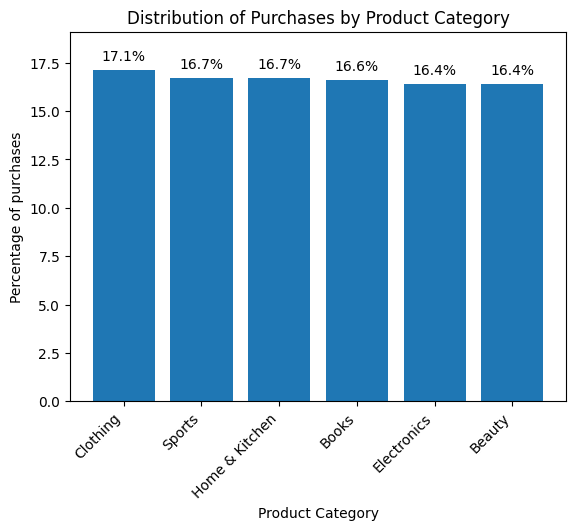

In [30]:
# Calculate and display the count and % of purchases per product category
product_counts = cleaned['Product Category'].value_counts()
product_perc = cleaned['Product Category'].value_counts(normalize=True) * 100

product_table = pd.DataFrame({
    'Count': product_counts,
    'Percentage (%)': product_perc.round(1) # round to match labels on bars
})

print(product_table)
print()

# Plot % in a bar chart
plt.figure()
plt.bar(
    product_table.index,
    product_table['Percentage (%)']
)
plt.title('Distribution of Purchases by Product Category')
plt.ylabel('Percentage of purchases')
plt.xlabel('Product Category')
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for i, v in enumerate(product_table['Percentage (%)']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Add some white space above the tallest bar to fit the labels
plt.ylim(0, product_table['Percentage (%)'].max() + 2)

plt.show()

**Distribution of Purchases by Product Category (bar chart)**

Clothing is the only product category above 17%, while the others range between 16.4-16.7%.

           Count  Percentage (%)
Country                         
France      1641           18.10
Canada      1528           16.80
Germany     1506           16.60
Australia   1478           16.30
UK          1467           16.20
USA         1456           16.00



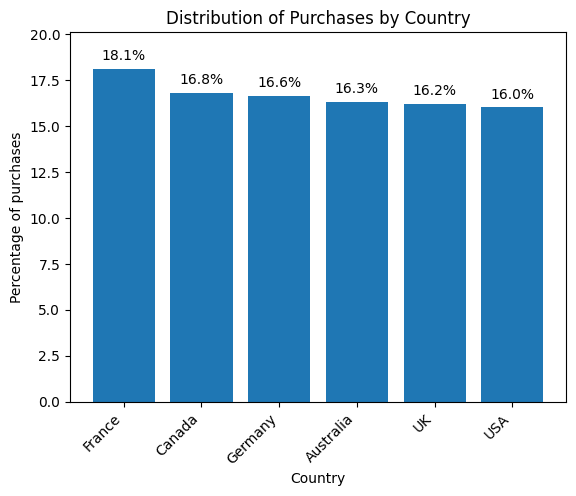

In [31]:
# Calculate and display the count and % of purchases per country
country_counts = cleaned['Country'].value_counts()
country_perc = cleaned['Country'].value_counts(normalize=True) * 100

country_table = pd.DataFrame({
    'Count': country_counts,
    'Percentage (%)': country_perc.round(1) # round to match labels on bars
})

print(country_table)
print()

# Plot % in a bar chart
plt.figure()
plt.bar(
    country_table.index,
    country_table['Percentage (%)']
)
plt.title('Distribution of Purchases by Country')
plt.ylabel('Percentage of purchases')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for i, v in enumerate(country_table['Percentage (%)']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Add some white space above the tallest bar to fit the labels
plt.ylim(0, country_table['Percentage (%)'].max() + 2)

plt.show()

**Distribution of Purchases by Country (bar chart)**

Users are relatively evenly distributed across countries, with France slightly dominating at 18.1%.

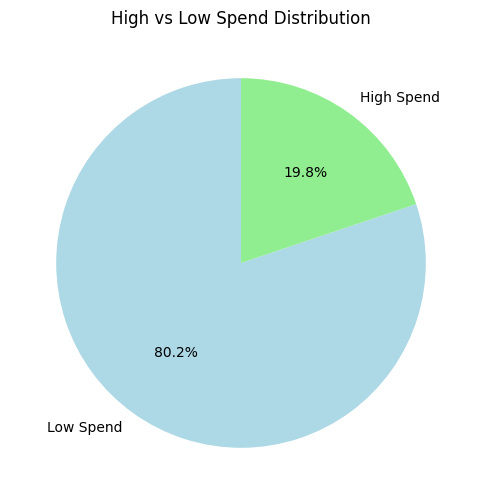

In [32]:
# Analyze High vs Low Spend

# Create a binary target variable to differenciate high vs low spenders
cleaned['High_Spend'] = (cleaned['Purchase Amount'] > 100).astype(int)

# Count how many 0s and 1s
high_spend_counts = cleaned['High_Spend'].value_counts()

# Show with a pie chart the proportion of the two types of spend
high_spend_counts.plot.pie(
    figsize=(6,6),
    autopct='%1.1f%%',  # show percentages
    labels=['Low Spend', 'High Spend'],
    startangle=90,  # rotate so first slice is at the top
    colors=['lightblue', 'lightgreen']
)
plt.ylabel('')  # remove y-label
plt.title('High vs Low Spend Distribution')
plt.show()


**High vs Low Spend Distribution**

About 20% of users are high spenders (purchase amount > 100), while the remaining 80% are low spenders.

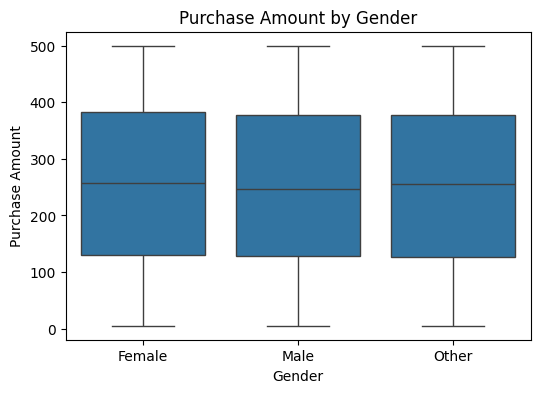

In [33]:
# Boxplot of purchase amount by gender
plt.figure(figsize=(6,4))
sns.boxplot(
    data=cleaned,
    x='Gender',
    y='Purchase Amount'
)
plt.title('Purchase Amount by Gender')
plt.ylabel('Purchase Amount')
plt.xlabel('Gender')
plt.show()


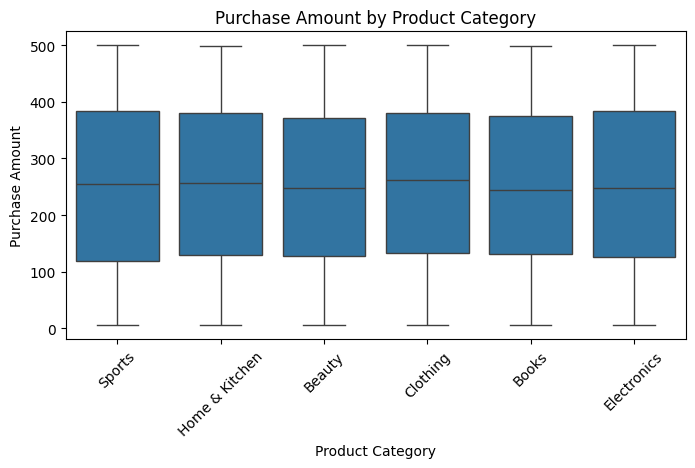

In [34]:
# Boxplot of purchase amount by product category

plt.figure(figsize=(8,4))
sns.boxplot(
    data=cleaned,
    x='Product Category',
    y='Purchase Amount'
)
plt.title('Purchase Amount by Product Category')
plt.ylabel('Purchase Amount')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.show()


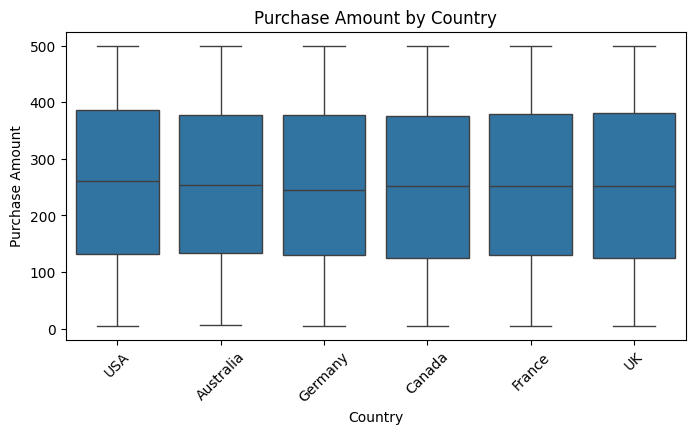

In [35]:
# Boxplot of purchase amount by country

plt.figure(figsize=(8,4))
sns.boxplot(
    data=cleaned,
    x='Country',
    y='Purchase Amount'
)
plt.title('Purchase Amount by Country')
plt.ylabel('Purchase Amount')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()


**Boxplots for Gender, Product Category, Country**

While bar charts show the percentage of purchases per category, boxplots highlight differences and variability in spending across genders, product categories, and countries.

Overall, spending is fairly consistent across categories, with minor differences:

* Men tend to spend slightly less than females or users in the “Other” category.
* Clothing is the product category with the highest median and variability in purchase amounts.
* Germany shows the lowest average spending among countries.


In [36]:
# Compute and display the time range of the dataset
print("Time range represented in the dataset")
print("First date in the dataset: ", cleaned['Purchase Date'].min())
print("Last date in the dataset: ", cleaned['Purchase Date'].max())

Time range represented in the dataset
First date in the dataset:  2020-01-01
Last date in the dataset:  2023-12-31


In [37]:
# Display purchases trend over time

# Extract year and month
cleaned['Year'] = pd.to_datetime(cleaned['Purchase Date']).dt.year
cleaned['Month'] = pd.to_datetime(cleaned['Purchase Date']).dt.month

# Display overall averages by year
print("Overall average purchase amounts by year")
yearly_avg = cleaned.groupby('Year')['Purchase Amount'].mean()
yearly_avg

Overall average purchase amounts by year


,Purchase Amount
Year,
2020,252.01
2021,250.98
2022,253.61
2023,253.18


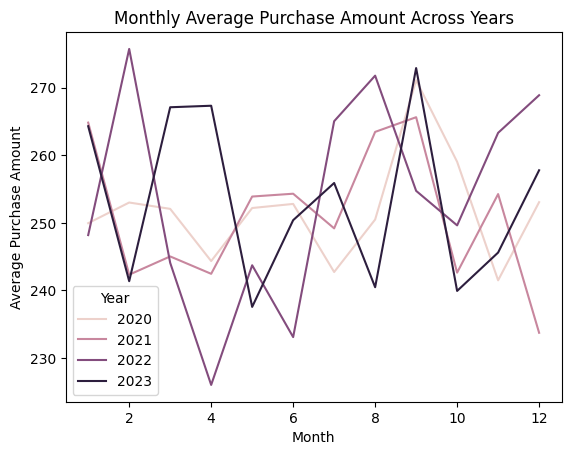

In [ ]:
# Create a lineplot with separate lines per year
sns.lineplot(
    data=cleaned,
    x='Month',
    y='Purchase Amount',
    hue='Year',
    estimator='mean',
    errorbar=None  # remove confidence interval area
)
plt.xlabel('Month')
plt.ylabel('Average Purchase Amount')
plt.title('Monthly Average Purchase Amount Across Years')
plt.show()

**Purchase Over Time**

While average purchase amounts by year are similar across the four years, the line chart shows distinct trends between 2020 and 2023.

2022 and 2023 show the strongest fluctuations, but in opposite directions for almost the entire 12 months.
The highest average purchase amount was registered in February 2022, followed by peaks from July to October for all four years, indicating seasonality in purchasing behaviour.

##**Summary of Insights**

The cleaned dataset contains 9,076 transactions from 2020 to 2023, across 6 countries, 6 product categories, and 3 gender groups, with users aged 18–69 and an average purchase amount of 252.44.

Demographics and product categories show only minor differences in purchase behaviour, while spending is fairly consistent across users. Age does not have a strong linear relationship with purchase amount. About 20% of users are high spenders (purchase amount > 100), while the majority are low spenders. Seasonal trends are visible, with peaks from July to October across all years. These observations provide an overview of how different factors influence purchase behaviour in this dataset.